# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [51]:
# import libraries
import sys
import pandas as pd 
import re
import pickle
from sqlalchemy import create_engine
from scipy.stats import gmean
from matplotlib import pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResDB.db')
df = pd.read_sql_table("DisasterResTable", engine)

print(f"Shape of DF after initially fetched: {df.shape}")
df.head()

Shape of DF after initially fetched: (26216, 40)


,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# First we have a look at the data description and distribution
df.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,...,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,...,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,...,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see that, as expected from the result of previous ETL pipeline, most of the columns have `1` and `0` values. However, there are one column called `child_alone` that only contains `0` values, which is meaningless in training. So we drop it.

Also, `related` column is supposed to only contain `1` and `0`, but we have value `2`. What is that?

In [4]:
df["related"].value_counts()

1    19906
0     6122
2      188
Name: related, dtype: int64

From the distinct value counts above, it seems `2` might be trash values/data outliers. Normally I will simply drop those rows, as I always do. But after second thought, this is a disaster response system, and doing this means I might doom those 188 poor souls, which is quite not particularly recommended. Thus, I will treat them as `1`.

In [5]:
df = df.drop("child_alone", axis = 1)
df.loc[
    df["related"] == 2,
    "related"
] = 1

# Check again
print(f"Shape of DF after some data wranglings: {df.shape}")
df.describe()

Shape of DF after some data wranglings: (26216, 39)


,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,...,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.766478,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,...,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.423079,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,...,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Define feature and target variables X and Y

X = df["message"]
print(f"10 samples of X: \n{X.sample(10)}\n")

Y = df.iloc[ : , 4 : ]
print(f"10 samples of Y:")
Y.sample(10)

10 samples of X: 
21170    The ability to refuel a helicopter while runni...
13591    Tornadoes are violently rotating storms of sma...
17418    The floods in Swat occurred at a time when the...
26155    We are committed to strengthening budget trans...
4685     It's not only Port-au-Prince that needs so muc...
18979    The recent military incursion by Kenyan forces...
11674    Getting slowly back to normal in Santiago\n\nI...
20075    These families have found refuge in improvised...
4631                     I would like to know what happen 
21452    All U.S. or non-U.S. non-governmental organiza...
Name: message, dtype: object

10 samples of Y:


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
7629,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22616,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
16542,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
26205,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
282,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13335,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Write a tokenization function to process your text data

In [7]:
def tokenize(texts):
    """
    Tokenize the texts based on NLP procedures.
    
    Parameters
    --------------
        text (str) : 
            input text messages
    
    Returns
    ----------
        clean_tokens (list) :
            list of tokens extracted from input text messages.
    """
    
    # Replaces URLs with placeholders
    url_regex = "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    for url in re.findall(url_regex, texts):
        texts = texts.replace(url, "url_placeholder")
    
    # Tokenization
    tokens = word_tokenize(texts)
    
    # Lemmy, lower, strip them (this sounds weird to say.... God forgive me)
    lemmy = WordNetLemmatizer()
    clean_tokens = []
    
    for token in tokens:
        clean_tokens.append(lemmy.lemmatize(token).lower().strip())
        
    return clean_tokens

We also need a Starting Verb Extractor transformer, too.

In [8]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    """
    Starting Verb Extractor class, as its name suggests, extracts the
    starting verb of a sentence, then creates a new feature for the
    ML classifier which will be used later.
    """

    def starting_verb(self, texts):
        """
        Check if the first word in a given text represents a verb.

        Parameters
        --------------
        text (str) : 
            the input text to analyze.

        Returns
        ---------
        (bool) : 
            True if the first word is a verb ("VB" or "VBP"), or if the first word
            is "RT" (indicating a retweet). False otherwise.
        """
        sentence_list = nltk.sent_tokenize(texts)
        
        for sentence in sentence_list:
            
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            
            if (first_tag in ["VB", "VBP"]) or (first_word == "RT"):
                return True
            
        return False

    def fit(self, X, y = None):
        """
        Fit the model to the input data.

        Parameters
        --------------
            X (list) :
                the input data for training the model.
            y (list) :
                (optional) target variable. Default is None.

        Returns
        ---------
            self : the fitted model.
        """
        return self

    def transform(self, X):
        """
        Transform the input data using the starting_verb method.

        Parameters
        --------------
            X (list or pd.DataFrame) :
                the input data to be transformed.

        Returns
        ---------
            (pd.DataFrame) : 
                a DataFrame containing Boolean values indicating whether
                the first word in each text represents a verb.
        """
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [9]:
pipeline1 = Pipeline([
        (
            "features", FeatureUnion([
                (
                    "text_pipeline", 
                    Pipeline([
                        (
                            "count_vectorizer", 
                            CountVectorizer(tokenizer = tokenize)
                        ),
                        (
                            "tfidf_transformer", 
                            TfidfTransformer()
                        )
                    ])
                )
            ])
        ),
    
        (
            "classifier",
            MultiOutputClassifier(AdaBoostClassifier())
        )
])

pipeline2 = Pipeline([
        (
            "features", FeatureUnion([
                (
                    "text_pipeline",
                    Pipeline([
                        (
                            "count_vectorizer", 
                            CountVectorizer(tokenizer = tokenize)
                        ),
                        (
                            "tfidf_transformer", 
                            TfidfTransformer()
                        )
                    ])
                ),
                (
                    "starting_verb_transformer", 
                    StartingVerbExtractor()
                )
            ])
        ),

        (
            "classifier", 
            MultiOutputClassifier(AdaBoostClassifier())
        )
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

pipeline1.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase...mator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [25]:
pred_Y_test = pipeline1.predict(X_test)

pred_report = classification_report(
    Y_test.values,
    pred_Y_test,
    target_names = Y.columns.values
)

In [58]:
# Split string into lines, remove empty lines
lines = [line.strip() for line in pred_report.strip().split('\n')]
# print(lines)

# Extract headers along with their data
headers = ["category"] + re.split(r'\s+', lines[0].strip())
data = [re.split(r'\s+', line.strip()) for line in lines[2:]]

# The last Avg/Total sucks, so trim-split it out
avgTotal = data.pop()
avgTotal = avgTotal[3 : ]
data.pop()
# print(data)
# print(avgTotal)

# Create a DataFrame
df_pred_report = pd.DataFrame(data, columns = headers)
df_pred_report.loc[len(df_pred_report)] = ["Average/Total"] + avgTotal

# Set the first column as the index

df_pred_report.head(len(df_pred_report))

,category,precision,recall,f1-score,support
0,related,0.82,0.95,0.88,4994
1,request,0.77,0.55,0.64,1111
2,offer,0.00,0.00,0.00,31
3,aid_related,0.78,0.60,0.68,2684
4,medical_help,0.61,0.25,0.35,502
5,medical_products,0.69,0.32,0.44,325
6,search_and_rescue,0.66,0.24,0.35,187
7,security,0.28,0.06,0.10,111
8,military,0.57,0.39,0.46,202
9,water,0.77,0.67,0.72,416


Overall Model Performance:

- Accuracy: weighted average F1-score (0.63) suggests that the model has reasonable performance across the classes, but there is room for improvement.

- Performance by Category:
    + High performance (F1-scores > 0.7) : `related`, `aid_related`, `weather_related`, `earthquake`.
    + Low performance (F1-scores < 0.3) : `offer`, `search_and_rescue`, `security`, `other_aid`, `infrastructure_related`, `tools`, `hospitals`, `shops`, `aid_centers`, `other_infrastructure`, `other_weather`. These categories exhibit challenges in precision and recall, probably due to imbalanced data.

- Recommendations for better performance:
    + Further tuning of the model, may be adjusting hyperparameters or trying different algorithms.
    + Addressing imbalanced classes through techniques such as oversampling, undersampling, or using class weights could enhance model predictions for minority classes.

### 6. Improve your model
Use grid search to find better parameters. 

In [83]:
parameters = {
        "classifier__estimator__n_estimators" : [10, 50],
        "classifier__estimator__learning_rate" : [0.5, 0.1]
    }
# The training takes forever so I have to reduce the number of `n_estimators` and `learning_rate`
# According to https://knowledge.udacity.com/questions/981709 and https://knowledge.udacity.com/questions/951789

model_improve1 = pipeline1

cv = GridSearchCV(
    model_improve1,
    param_grid = parameters,
    scoring = "f1_micro",
    cv = 2,
    n_jobs = -1,             # All processors go boom!
    verbose = True
)

cv.fit(X_train, Y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  4.9min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  9.0min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase...mator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'classifier__estimator__n_estimators': [10, 50], 'classifier__estimator__learning_rate': [0.5, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=True)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [84]:
pred_Y_test_improve1 = cv.predict(X_test)

pred_report_improve1 = classification_report(
    Y_test.values,
    pred_Y_test_improve1,
    target_names = Y.columns.values
)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [85]:
# Split string into lines, remove empty lines
lines = [line.strip() for line in pred_report_improve1.strip().split('\n')]
# print(lines)

# Extract headers along with their data
headers = ["category"] + re.split(r'\s+', lines[0].strip())
data = [re.split(r'\s+', line.strip()) for line in lines[2:]]

# The last Avg/Total sucks, so trim-split it out
avgTotal = data.pop()
avgTotal = avgTotal[3 : ]
data.pop()
# print(data)
# print(avgTotal)

# Create a DataFrame
df_pred_report_improve1 = pd.DataFrame(data, columns = headers)
df_pred_report_improve1.loc[len(df_pred_report_improve1)] = ["Average/Total"] + avgTotal

df_pred_report_improve1.head(len(df_pred_report_improve1))

,category,precision,recall,f1-score,support
0,related,0.79,0.97,0.87,4994
1,request,0.81,0.50,0.62,1111
2,offer,0.00,0.00,0.00,31
3,aid_related,0.78,0.56,0.65,2684
4,medical_help,0.67,0.13,0.22,502
5,medical_products,0.83,0.22,0.34,325
6,search_and_rescue,0.77,0.14,0.24,187
7,security,0.50,0.03,0.05,111
8,military,0.65,0.21,0.32,202
9,water,0.78,0.65,0.71,416


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [50]:
# Now we bring forth the Pipeline 2, including an additional Starting Verb Estimator

model_improve2 = pipeline2
model_improve2.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase...mator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
           n_jobs=1))])

In [54]:
pred_Y_test_improve2 = model_improve2.predict(X_test)

pred_report_improve2 = classification_report(
    Y_test.values,
    pred_Y_test_improve2,
    target_names = Y.columns.values
)

In [78]:
# Split string into lines, remove empty lines
lines = [line.strip() for line in pred_report_improve2.strip().split('\n')]
# print(lines)

# Extract headers along with their data
headers = ["category"] + re.split(r'\s+', lines[0].strip())
data = [re.split(r'\s+', line.strip()) for line in lines[2:]]

# The last Avg/Total sucks, so trim-split it out
avgTotal = data.pop()
avgTotal = avgTotal[3 : ]
data.pop()
# print(data)
# print(avgTotal)

# Create a DataFrame
df_pred_report_improve2 = pd.DataFrame(data, columns = headers)
df_pred_report_improve2.loc[len(df_pred_report_improve2)] = ["Average/Total"] + avgTotal

df_pred_report_improve2.head(len(df_pred_report_improve2))

,category,precision,recall,f1-score,support
0,related,0.82,0.95,0.88,4994
1,request,0.77,0.55,0.64,1111
2,offer,0.00,0.00,0.00,31
3,aid_related,0.78,0.60,0.68,2684
4,medical_help,0.61,0.25,0.35,502
5,medical_products,0.69,0.32,0.44,325
6,search_and_rescue,0.66,0.24,0.35,187
7,security,0.28,0.06,0.10,111
8,military,0.57,0.39,0.46,202
9,water,0.77,0.67,0.72,416


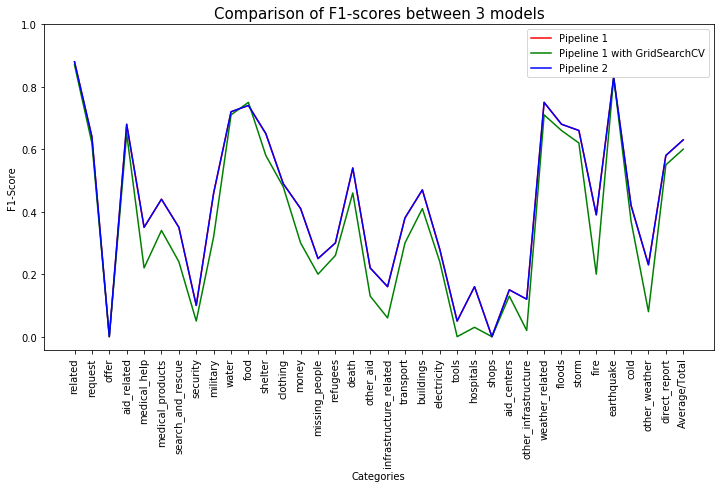

In [86]:
# Compare 3 models together in terms of F1 score
f1_0 = [float(x) for x in df_pred_report["f1-score"].tolist()]
f1_improve1 = [float(x) for x in df_pred_report_improve1["f1-score"].tolist()]
f1_improve2 = [float(x) for x in df_pred_report_improve2["f1-score"].tolist()]
categories = df_pred_report["category"].tolist()

plt.figure(figsize = (12, 6))
plt.plot(f1_0, color = "red", label = "Pipeline 1")
plt.plot(f1_improve1, color = "green", label = "Pipeline 1 with GridSearchCV")
plt.plot(f1_improve2, color = "blue", label = "Pipeline 2")

plt.xlabel("Categories", fontsize = 10)
plt.xticks(range(len(f1_0)), categories, rotation = 90)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylabel("F1-Score", fontsize = 10)
plt.title("Comparison of F1-scores between 3 models", fontsize = 15)
plt.legend(fontsize = 10)

If you are wondering, then yes, the Pipeline 1 and Pipeline 2 has the same F1 scores on all categories, which I don't know why, still don't know why.

Apparently, we can see that, Pipeline 1 with GridSearchCV, even with a rudimentary hyperparameter setting (due to resource performance), still perform somewhat better than those 2 original pipelines.

Thus, I decided to use Pipeline 1 with GridSearchCV.

### 9. Export your model as a pickle file

In [87]:
with open("best_model.pkl", "wb") as f:
    pickle.dump(cv, f)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.